# MUDE W3- Gradient Estimation 



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>

<b>Info:</b> 

This notebook is a very simple draft showing how we could use data from the ~~Nenana Ice Classic~~ (from any of the column in our dateset) for the numerical modelling part of MUDE.

The implementation is not particularly efficient, but it is quite flexible.


The dataset used is direclty loaded from github, so a a few extra packages are needed(`io` and  `requests`) but we could avoid using 'non-standard'libraries by downloading the file and loading it 'manually'.


</p>
</div>


In [4]:
from io import StringIO
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly 

def import_data_browser(url):
    """
    This function imports data from a specified URL.

    Parameters:
    url (str): The URL from which to import the data.

    Returns:
    None

    Comments:
    This function is needed to load data in a browser, as the environment used does not support absolute/relative path imports 
    """
   
    response = requests.get(url)
    csv_data = StringIO(response.text)

    return csv_data


# Loading the dataset

In [5]:

# we could load the data from the repo
file=import_data_browser('https://raw.githubusercontent.com/iceclassic/mude/main/book/data_files/time_serie_data.txt')
Data=pd.read_csv(file,skiprows=162,index_col=0,sep='\t')
Data.index = pd.to_datetime(Data.index, format="%Y-%m-%d")
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39309 entries, 1901-02-01 to 2024-02-06
Data columns (total 28 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Regional: Air temperature [C]                      38563 non-null  float64
 1   Days since start of year                           38563 non-null  float64
 2   Days until break up                                38563 non-null  float64
 3   Nenana: Rainfall [mm]                              29547 non-null  float64
 4   Nenana: Snowfall [mm]                              19945 non-null  float64
 5   Nenana: Snow depth [mm]                            15984 non-null  float64
 6   Nenana: Mean water temperature [C]                 2418 non-null   float64
 7   Nenana: Mean Discharge [m3/s]                      22562 non-null  float64
 8   Nenana: Air temperature [C]                        31171 non-null  fl

## Estimating gradients


In [66]:
def finite_differences(series:pd.Series):
    """
    Computes forward, central, and backward differences using the step size as days between measurement.
    
    Parameters
    ---------
    series: pd.Series
        Series with datetime index 
    
    Returns
    ---------
    df: pd.DataFrame
        DataFrame with forward, backward and central differences for the Series
    
    """
   
    days_forward = (series.index.to_series().shift(-1) - series.index.to_series()).dt.days
    days_backward = (series.index.to_series() - series.index.to_series().shift(1)).dt.days
    
    # Forward difference: (f(x+h) - f(x)) / h 
    forward = (series.shift(-1) - series) / days_forward

    # Backward difference: (f(x) - f(x-h)) / h,
    backward = (series - series.shift(1)) / days_backward

    # Central difference: (f(x+h) - f(x-h)) / (h_forward + h_backward)
    central = (series.shift(-1) - series.shift(1)) / (days_forward + days_backward) #
    
    # fixing start/end points
    forward.iloc[-1] = np.nan  
    backward.iloc[0] = np.nan  

    return pd.DataFrame({'forward': forward, 'backward': backward, 'central': central})

def plot_gradients(ax:plt.axes,
                    x:pd.Series, 
                    y:pd.Series,
                    slopes:pd.Series,
                    length: int= 2,
                    color: str='blue',
                    label:str=None,
                    label_flag: bool=True,
                    offset: int=0 ):
    """
    Plot gradient slopes and annotate them.
    
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes to plot on.
    x : pd.Series
        The x-values of the data points.
    y : pd.Series
        The y-values of the data points.
    slopes : pd.Series
        The slopes of the data points. Each column column corresponds to a different gradient type.
    length : int, optional
        The length of the gradient line. Default is 2.
    color : str, optional   
        The color of the gradient line. Default is 'blue'.
    label : str, optional
        The label of the gradient line. Default is None.
    label_flag : bool, optional
        Whether to show the label. Default is True.
    offset : int, optional
        The offset of the annotation. Default is 0. Use to avoid overlapping annotations.

    Returns
    -------
    annotations : list
        A list of annotations of the value of the gradient at each point, using all the graudient types.
    """
    #
    # (annotations)code shamelessly stolen from chatgpt 
    annotations = []
    for i in range(len(x)):
        if np.isnan(slopes.iloc[i]):
            continue  
        dx = length  
        dy = slopes.iloc[i] * dx  
        
        ax.plot(
            [x[i], x[i] + pd.Timedelta(days=dx)], 
            [y.iloc[i], y.iloc[i] + dy], 
            color=color, alpha=0.7, label=label if label_flag else ""
        )
        
        annotations.append({
            'x': x[i] + pd.Timedelta(days=dx / 2),
            'y': y.iloc[i] + offset,
            'text': f'{slopes.iloc[i]:.2f}',
            'color': color
        })
        label_flag = False  #


    for annotation in annotations:
        ax.annotate(
            annotation['text'], 
            (annotation['x'], annotation['y']), 
            color=annotation['color'], fontsize=10, ha='center'
        )


def plot_gradients_and_thickness(result:pd.DataFrame,
                                 col:pd.Series, 
                                 year:int, 
                                 plot_gradient_as_slope:bool=False,
                                 Title: str=None ,
                                 ylabel: str=None,
                                 xlim: list=['01/01', '12/31'],
                                 ylim: list=None,
                                 annotation_offsets: dict= {'forward': -3, 'backward': -6, 'central': -9}):
    """
    Plots ice thickness gradients and ice thickness for a selected year.

    Parameters
    ----------
    result: pd.DataFrame
        DataFrame containing the gradients with columns ['forward', 'backward', 'central'].
    col: pd.Series
         Series containing the columns values indexed by datetime.
    year: int
        The year to filter and plot data for.
    plot_gradient_as_slope: bool
        If True, plots lines with gradients and annotations.
    Title: str
        title of the plot
    ylabel: str
        ylabel of the plot
    ylim: list
        y-axis limits for the plot. List should be in the format [(MM/DD),(MM/DD)].
    annotation_offsets: dict
        The offset of the annotation. Default value assume that the series has three column corresponding to 
        forward, backward and central. Use to avoid overlapping annotations. The value corresponds to the y-axis value.
        
    Returns
    -------
    plt.figure
    """
    
    result_year = result[result.index.year == year]
    col_year = col[col.index.year == year]

    xlimits=pd.to_datetime([str(year) + '/' + e for e in xlim])

    
    if not plot_gradient_as_slope:
        fig, ax1 = plt.subplots(figsize=(20, 5))

        ax1.plot(result_year['forward'], label='Forward', color='red')
        ax1.plot(result_year['backward'], label='Backward', color='green')
        ax1.plot(result_year['central'], label='Central', color='blue')

        ax1.set_ylabel(ylabel)
        ax1.set_xlabel('Date')
        ax1.set_title(Title)
        ax1.grid()


        ax1.set_xlim(xlimits)
        ax1.set_ylim(ylim)

      
        #ax1.set_xlim(result_year.index.min(), result_year.index.max())
        ax1.legend(loc='upper left')

      
        ax2 = ax1.twinx()
        ax2.scatter(col_year.index, col_year, color='black', alpha=0.4, label='data')
        ax2.plot(col_year.index, col_year, color='black', alpha=0.4)
        

       
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper right')

        plt.show()
    else:
        fig, ax = plt.subplots(figsize=(20, 5))

        ax.plot(col_year.index, col_year, label='Thickness', color='black', linestyle='--', alpha=0.4)
        ax.scatter(col_year.index, col_year, color='black', alpha=0.4)

      
        offsets = annotation_offsets
        
        for grad_type, color in zip(['forward', 'backward', 'central'], ['red', 'green', 'blue']):
            slopes = result_year[grad_type]
            plot_gradients(ax, result_year.index, col_year, slopes, color=color, label=grad_type.capitalize(), label_flag=True, offset=offsets[grad_type])

        ax.legend()
        ax.set_title(Title)
        ax.set_xlabel('Date')
        ax.set_ylabel(ylabel)
        ax.set_xlim(xlimits)
        ax.set_ylim(ylim)
        ax.grid(True)
        plt.show()



# Ice thickness

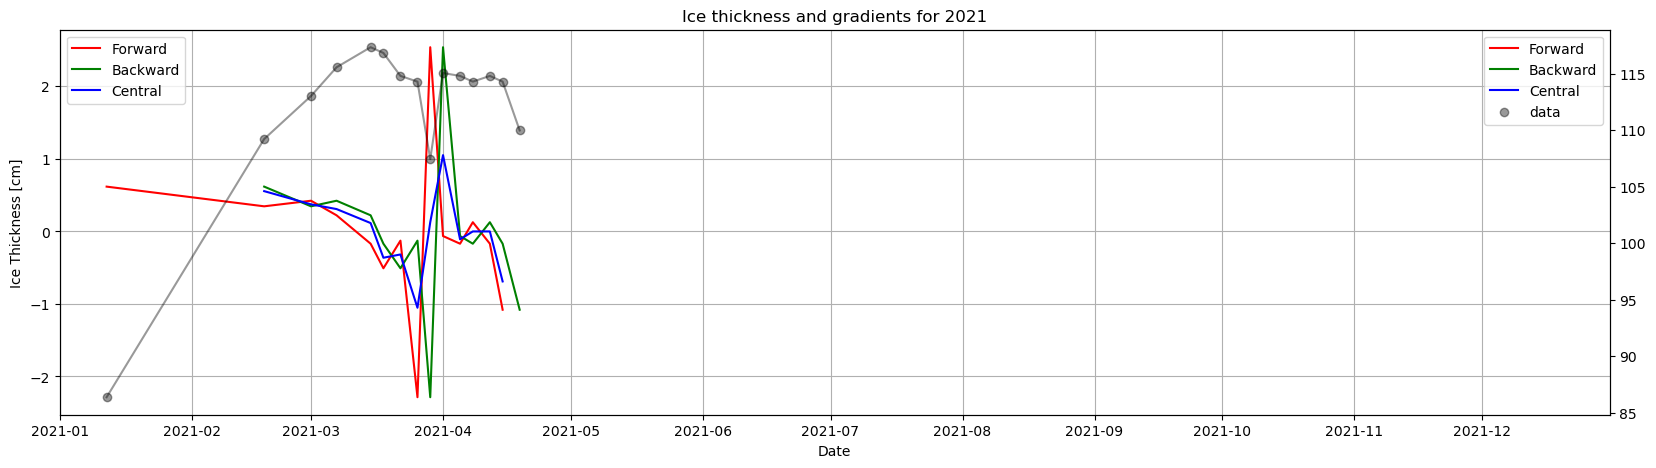

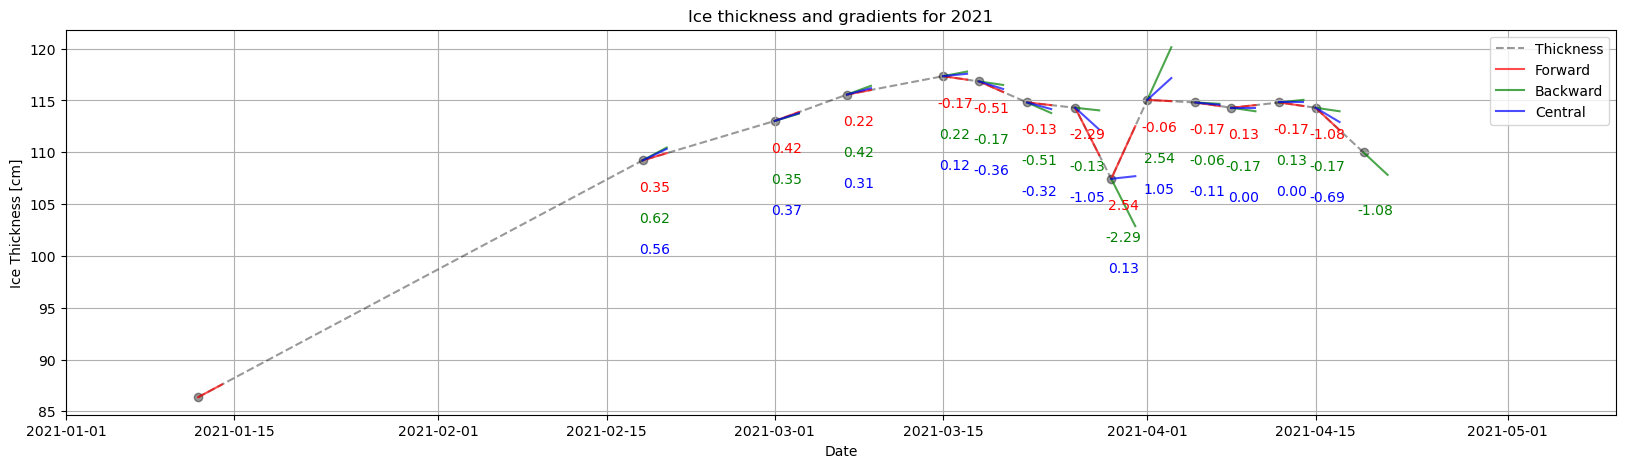

In [59]:

Ice_thickness=Data['IceThickness [cm]']
Ice_thickness=Ice_thickness.dropna(inplace=False)
result = Ice_thickness.groupby(Ice_thickness.index.year,group_keys=True).apply(lambda x: finite_differences(x)).reset_index(level=0, drop=True)
plot_gradients_and_thickness(result, Ice_thickness, 2021,Title='Ice thickness and gradients for 2021',ylabel='Ice Thickness [cm]')
plot_gradients_and_thickness(result, Ice_thickness, 2021,plot_gradient_as_slope=True,xlim=['01/01', '05/10'],
                             Title='Ice thickness and gradients for 2021',ylabel='Ice Thickness [cm]')


## Discharge

>  fix plotting function, so than  when selecting an xlim, the function only compute the data in that range, right now it computes all the data and then restricts the plot which is slow 

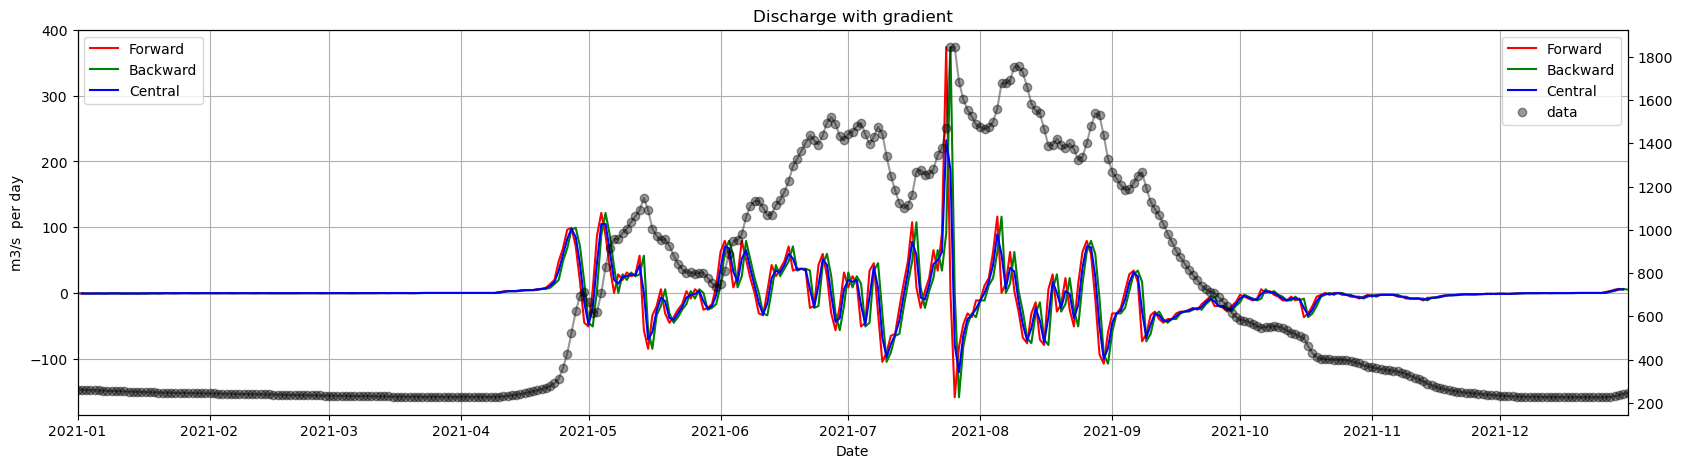

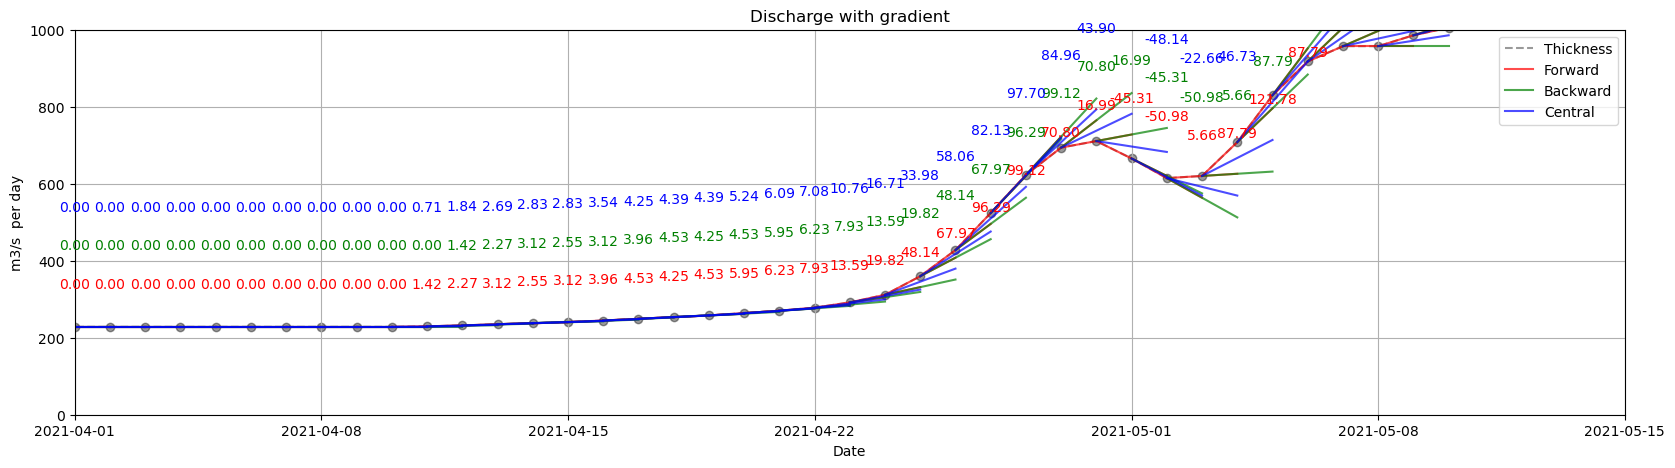

In [70]:
Discharge=Data['Nenana: Mean Discharge [m3/s]']
Discharge=Discharge.dropna(inplace=False) # drop the missing values
result_2 = Discharge.groupby(Discharge.index.year,group_keys=True).apply(lambda x: finite_differences(x))
result_2 = result_2.reset_index(level=0, drop=True)
plot_gradients_and_thickness(result_2, Discharge, 2021,Title='Discharge with gradient',ylabel='m3/s  per day')
plot_gradients_and_thickness(result_2, Discharge, 2021,plot_gradient_as_slope=True,xlim=['04/01', '05/15'],
                             Title='Discharge with gradient',ylabel='m3/s  per day',ylim=[0, 1000],
                             annotation_offsets={'forward': 100, 'backward': 200, 'central': 300})
#


## Gage Height


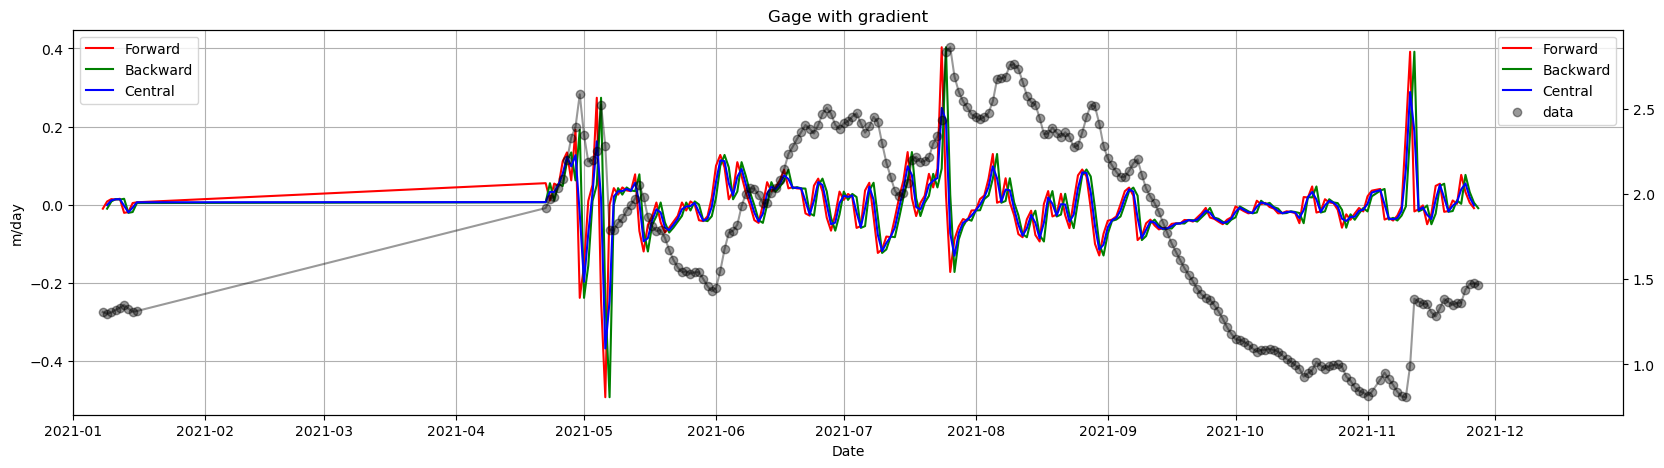

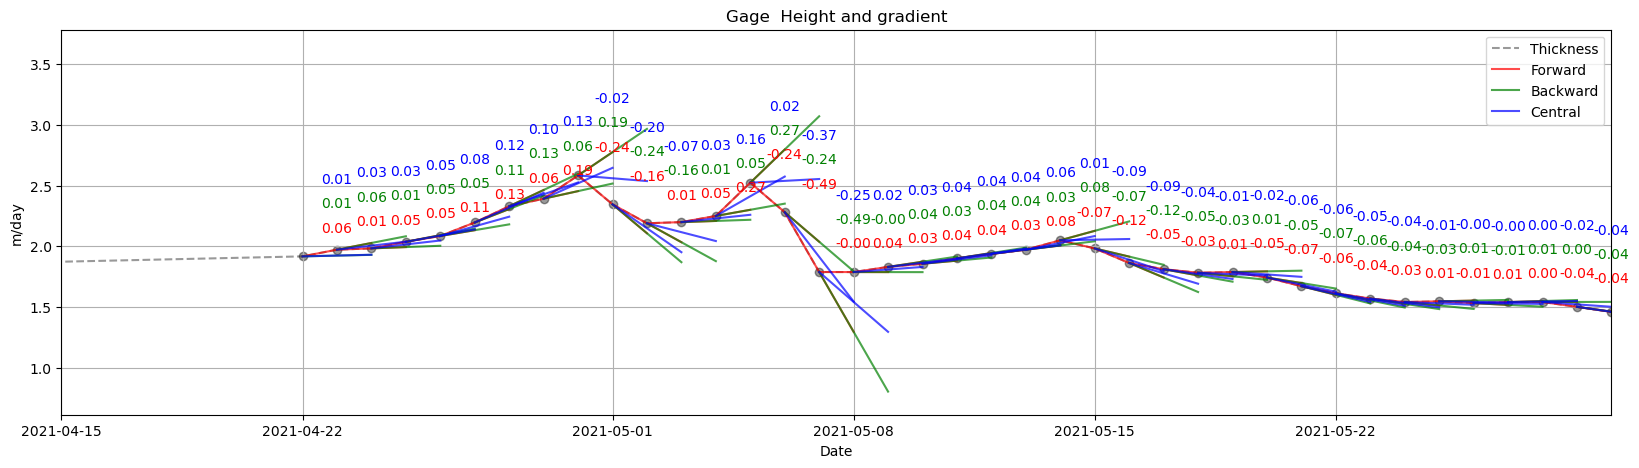

In [81]:
Gage=Data['Nenana: Gage Height [m]']
Gage=Gage.dropna(inplace=False) # drop the missing values
result_3 = Gage.groupby(Gage.index.year,group_keys=True).apply(lambda x: finite_differences(x))
result_3 = result_3.reset_index(level=0, drop=True)
plot_gradients_and_thickness(result_3, Gage, 2021,Title='Gage with gradient',ylabel='m/day')
plot_gradients_and_thickness(result_3, Gage, 2021,plot_gradient_as_slope=True,xlim=['04/15', '05/30'],
                             annotation_offsets={'forward': 0.2, 'backward': 0.4, 'central': 0.6},
                             ylabel='m/day',Title='Gage  Height and gradient')

<div style="background-color:#CABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>

<b>Pypi:</b> 
 Upload this to Pypi package once the the feedback has been integrated, ( there are a few other modification to the functions.py that I'll release as well)
</p>
</div>